# Homework 3



### Project update

In addition to the coding problems below, please submit a short project update.
In this update, you should describe 
- Your progress so far. Are you on track given what you described in your proposal?
- Any unexpected challenges you have facing and how you are adapting your project around that.
- What remains to be done.
- Any other updates or results you may want to share.

Please submit this as a separate PDF as part of your homework submission.

Excluding figures/tables, etc, this should be no more than 1 page.

### Instructions (Code problems)
Download this jupyer notebook (button at the top of the page or download from the Github repository). Provide your answers as Markdown text, Python code, and/or produce plots as appropriate. The notebook should run all the cells in order without errors.  
Submit both the `.ipynb` and a `.pdf` to Canvas.

Make sure the `.pdf` has all the relevant outputs showing. To save as `.pdf` you can first export the notebook as `.html`, open it in a browers and then "Print to PDF". 

**NOTE:** As we will be sharing the files for peer grading, please keep your submission anonymous.

### Problem 1 (Extended Kalman Filter)

Consider a unicycle model

$$ \dot{\mathbf{x}} = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix} = \begin{bmatrix} v\cos\theta \\ v\sin\theta \\ \omega \end{bmatrix}, \qquad \mathbf{u} = \begin{bmatrix} v \\ \omega \end{bmatrix} $$

Let the *discrete time* dynamics with Gaussian noise be given by the following.

$$ \mathbf{x}_{t+1} = f_d(\mathbf{x}_t, \mathbf{u}_t) + \mathbf{w}_t, \quad \mathbf{w}_t \sim \mathcal{N}(0, Q) $$ 

where $\mathbb{E}[\mathbf{w}_t\mathbf{w}_t^T] = Q$.

Assume that we only obtain GPS position measurements of the robot. The measurement model is

$$ \mathbf{y}_t = \begin{bmatrix} x_t\\ y_t \end{bmatrix} + \mathbf{v}_t $$ 

where $\mathbb{E}[\mathbf{v}_t\mathbf{v}_t^T] = R$.


In this problem, let $\Delta t = 0.1$, $Q = \mathrm{diag}([0.05, 0.05, 0.01])$, and $R=\mathrm{diag}([2.0, 2.0])$. 

Suppose that at the beginning, our estimate of the initial state is $\mathbf{x}_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$ where $\mu_0 = \begin{bmatrix} -4.0\\ 4.0\\ \frac{\pi}{4} + 0.5 \end{bmatrix}$, $\Sigma_0 = \mathrm{diag}([8., 8., 2.])$.
During the episode, the robot is executing control inputs according to the control law: 

$$\mathbf{u}_k = \begin{bmatrix} 0.5\sin(0.5t_k) + 1 \\ \sin(t_k) \end{bmatrix}.$$

Let the *true* initial state of the system be $\mathbf{x}_0^\mathrm{true} = \begin{bmatrix} 0.0\\ 0.0\\ \frac{\pi}{4} \end{bmatrix}$.
Note that in "real life" we don't the know the exact ground truth value of the robot's state, but in this problem, it is given so that you can compare your estimate and generate noisy measurements.

In the following code cell, you will be required to implement an **Extended Kalman Filter**, and simulate the system (both the ground truth trajectory and the estimated trajectory).

In [1]:
!pip install dynamaxsys==0.0.5

  Attempting uninstall: dynamaxsys
    Found existing installation: dynamaxsys 0.0.3
    Uninstalling dynamaxsys-0.0.3:
      Successfully uninstalled dynamaxsys-0.0.3


In [2]:

# in this problem, we will use the dynamaxsys library to import dynamical systems implemented in JAX: https://github.com/UW-CTRL/dynamaxsys
from dynamaxsys.unicycle import Unicycle
from dynamaxsys.base import get_discrete_time_dynamics
from dynamaxsys.utils import linearize

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from scipy.stats import chi2



In [3]:
# some helper functions. No need to change these functions

def wrap_to_pi(a):
    '''
    Wrap angle to [-pi, pi].
    '''
    return (a + np.pi) % (2 * np.pi) - np.pi

def plot_uncertainty_ellipse(ax, mean, cov, confidence=0.95, dim=2, **kwargs):
    """
    Plot an uncertainty ellipse based on the covariance matrix.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    chi2_val = chi2.ppf(confidence, df=dim)
    width, height = 2 * np.sqrt(chi2_val * eigenvalues)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

### (a) Implement the EKF step

In [4]:
# This is the EKF step. 
# You will need to implement the EKF step in the function below.
# The EKF step consists of two main parts: the prediction step and the update step.
# In the prediction step, we use the robot dynamics to predict the next state and its covariance.
# In the update step, we use the measurement to update the predicted state and covariance.

def ekf_step(x, P, u, z, Q, R, dt_robot_dynamics, measurement_model):
    """
    Perform one step of the EKF algorithm.
    Inputs:
        x: state estimate at time t-1
        P: covariance estimate at time t-1
        u: control input at time t-1
        z: measurement at time t
        Q: process noise covariance
        R: measurement noise covariance
        dt_robot_dynamics: discrete-time robot dynamics function
        measurement_model: measurement model function
    Outputs:
        x_upd: updated state estimate at time t
        P_upd: updated covariance estimate at time t    
    """
    t = 0. # time is not used in this example, but a dummy value is needed for the function signature
    
    # Prediction step
    # predict the next state given known robot dynamics
    # x_pred = ...
    x_pred = dt_robot_dynamics(x, u)
    # predict the next covariance given known robot dynamics
    # Compute A matrix 
    # HINT: use the linearize function from the dynamaxsys package: https://github.com/UW-CTRL/dynamaxsys/blob/main/dynamaxsys/utils.py#L17
    # A = ...
    A, b, c = linearize(dt_robot_dynamics, x, u, t)
    # P_pred = ...
    P_pred = A @ P @ A.T + Q
    # Update step
    # compute innovation (residual)
    # h = ...
    h = z - measurement_model(x_pred, u, t)
    
    # Compute C matrix
    # C = ...
    C, d, e = linearize(measurement_model, x_pred, u, t)
    # Compute Kalman gain
    # K = ...
    K = P_pred @ C.T @ np.linalg.inv(C @ P_pred @ C.T + R)
    # Update the state estimate and covariance
    # x_upd = ...
    x_upd = x_pred + K @ h
    # P_upd = ...
    P_upd = (jnp.eye(P_pred.shape[0]) - K @ C) @ P_pred
    return x_upd, P_upd # UPDATE THIS LINE


### (b) Set up the rest of the problem parameters and functions

In [5]:
# set up robot dynamics 
# we can use the dynamaxsys library to import the robot dynamics
# the robot dynamics is a unicycle model
dt = 0.1
ct_robot_dynamics = Unicycle() # robot dynamics
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # get discrete time dynamics (uses RK4 integrator)
state_dim = dt_robot_dynamics.state_dim

#### Set up the robot control function

In [6]:
def u_func(t):
    '''
    Control input function.
    This function generates a control input based on the time t.
    u = [v, omega]
    '''
    
    ##### FILL IN CODE HERE #####
    u = jnp.array([0.5 * jnp.sin(0.5 * t), jnp.sin(t)])
    # return jnp.array([0.5, 0.1]) # UPDATE THIS LINE
    return u
    ##### END OF CODE #####




### Define the robot measurement model (without noise)

In [7]:
obs_dim = 2
def measurement_model(state, control, time):
    ##### FILL IN CODE HERE #####
    x, y, theta = state
    return jnp.array([x, y]) # UPDATE THIS LINE
    ##### END OF CODE #####


### Define problem matrices and other variables

In [8]:

##### FILL IN CODE HERE #####
## UPDATE ALL THESE VALUES
# P0 = jnp.eye(state_dim) # initial state estimate covariance
# Q = jnp.eye(state_dim) # process noise covariance
# R = jnp.eye(obs_dim) # measurement noise covariance
# x0 = jnp.zeros([state_dim]) # true initial state

P0 = jnp.diag(jnp.array([8., 8., 2.])) # initial state estimate covariance
Q = jnp.diag(jnp.array([0.5, 0.5, 0.01])) # process noise covariance
R = jnp.diag(jnp.array([2., 2.])) # measurement noise covariance
x0 = jnp.array([0., 0., jnp.pi / 4]) # true initial state


### (c) Simulate the episode!

In [9]:
n_timesteps = 100 # number of timesteps of run

# set up lists to store the state estimates, true states, covariances, measurements, and times
xs_est = [x0 + jnp.array([-4.0, 4.0, 0.5])] # initial state
xs_true = [x0]
Ps = [P0] # initial covariance
measurements = []
ts = []

# seed the random number generator
# and sample the process noise and measurement noise
key = jax.random.PRNGKey(0)
dyn_noise = jax.random.multivariate_normal(key, jnp.zeros(state_dim), Q, shape=(n_timesteps,)) # sample from the process noise
measurement_noise = jax.random.multivariate_normal(key, jnp.zeros(obs_dim), R, shape=(n_timesteps,)) # sample from the measurement noise

######## TODO: FILL IN CODE BELOW ########
# most is commented out so the notebook will run without errors
# but you need to uncomment relevant lines and fill in the code


# run the EKF algorithm over multiple timesteps
for ti in range(n_timesteps):
    t = ti * dt # get time
    ts.append(t)
    
    # get the control input
    # u = ...  # TODO: UPDATE THIS LINE 
    u = u_func(t)
    
    # get the true state with process noise
    # x_next_true = ... # TODO: UPDATE THIS LINE
    x_next_true = dt_robot_dynamics(xs_true[ti], u, t) + dyn_noise[ti] # TODO: UPDATE THIS LINE
    
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    x_next_true = x_next_true.at[2].set(wrap_to_pi(x_next_true[2])) 
    
    # get the measurement with measurement noise
    # z = ... # TODO: UPDATE THIS LINE
    z = measurement_model(xs_true[ti], u, t) + measurement_noise[ti]
    
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    z = z.at[2].set(wrap_to_pi(z[2]))
    
    # perform one step of the EKF algorithm
    # x, P = ... # TODO: UPDATE THIS LINE
    x, P = ekf_step(xs_est[-1], Ps[-1], u, z, Q, R, dt_robot_dynamics, measurement_model)
    
    
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    x = x.at[2].set(wrap_to_pi(x[2]))
    
    # add the new state estimate, true state, covariance, and measurement to the lists
    # TODO: uncomment the lines below
    xs_est.append(x)
    xs_true.append(x_next_true)
    measurements.append(z)
    Ps.append(P)


# TODO: uncomment the lines below

ts.append(n_timesteps * dt)
xs_est = jnp.stack(xs_est)
xs_true = jnp.stack(xs_true)
measurements = jnp.stack(measurements)
Ps = jnp.stack(Ps)
ts = jnp.array(ts)

Plot your results below!
Uncomment the plotting code below to see your results!

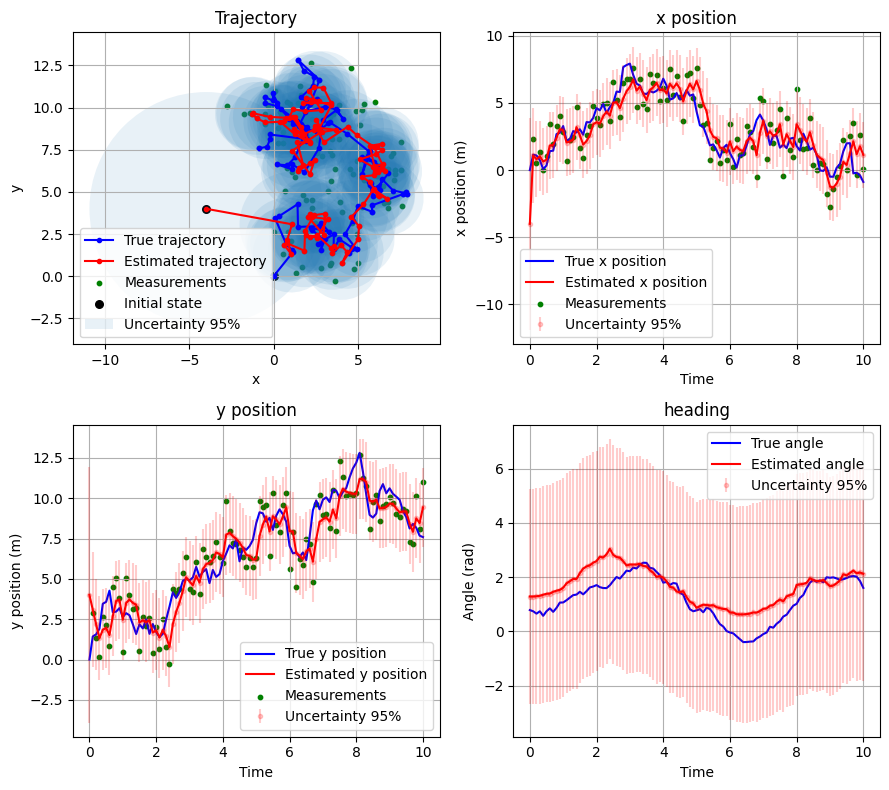

In [10]:
confidence = 0.95
scale = jnp.sqrt(chi2.ppf(0.95, df=3))

plt.figure(figsize=(9, 8))
plt.subplot(2,2,1)
ax = plt.gca()
plt.plot(xs_true[:, 0], xs_true[:, 1], 'o-', label='True trajectory', color='blue', markersize=3)
plt.plot(xs_est[:, 0], xs_est[:, 1], 'o-', label='Estimated trajectory', color='red', markersize=3)
plt.scatter(xs_true[:, 0], xs_true[:, 1], color='blue', s=10)
plt.scatter(xs_est[:, 0], xs_est[:, 1], color='red', s=10)
plt.scatter(measurements[:, 0], measurements[:, 1], color='green', s=10, label='Measurements')
plt.scatter(xs_est[0, 0], xs_est[0, 1], color='black', s=30, label='Initial state')
plt.scatter(xs_true[0, 0], xs_true[0, 1], color='black', s=30)

plot_uncertainty_ellipse(ax, xs_est[0][:2], Ps[0][:2,:2], confidence=0.95, alpha=0.1, label="Uncertainty 95%")
for (mu, sigma) in zip(xs_est[1:], Ps[1:]):
    plot_uncertainty_ellipse(ax, mu[:2], sigma[:2,:2], confidence=0.95, alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.grid()

plt.subplot(2,2,2)
plt.plot(ts, xs_true[:, 0], label='True x position', color='blue')
plt.plot(ts, xs_est[:, 0], label='Estimated x position', color='red')
plt.scatter(ts[1:], measurements[:, 0], color='green', s=10, label='Measurements')
plt.errorbar(ts, xs_est[:, 0], yerr=scale * jnp.sqrt(Ps[:, 0, 0]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('x position (m)')
plt.title('x position')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(ts, xs_true[:, 1], label='True y position', color='blue')
plt.plot(ts, xs_est[:, 1], label='Estimated y position', color='red')
plt.scatter(ts[1:], measurements[:, 1], color='green', s=10, label='Measurements')
plt.errorbar(ts, xs_est[:, 1], yerr=scale * jnp.sqrt(Ps[:, 1, 1]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('y position (m)')
plt.title('y position')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(ts, xs_true[:, 2], label='True angle', color='blue')
plt.plot(ts, xs_est[:, 2], label='Estimated angle', color='red')
plt.errorbar(ts, xs_est[:, 2], yerr=scale * jnp.sqrt(Ps[:, 2, 2]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.title('heading')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## (d) EKF-SLAM
The EKF algorithm is not only useful for estimating the state of the robot, but it can also be used to estimate the location of landmarks in the environment. That is, we can use the EKF algorithm estimate both the robot state (i.e., localization) and also estimate a map of its surrounding (i.e., mapping). This is referred to as SLAM--Simultaneous Localization And Mapping.

In this problem we will implement a *very simple* SLAM problem by using the above code, but we add one new landmark to the problem whose position we wish to estimate.

The core idea is to augment the state vector with the location of the landmark. Essentially treat the landmark location as part of the state, update the measurement model and other matrices accordingly, and then apply the same old EKF algorithm on this augmented problem. 

(Note: This is a nice example where the algorithm we use is relatively straightforward, but by carefully formulating the problem a certain way, these "simple" algorithms can be very powerful!)

In addition to the GPS measurements, the robot receives noisy range and bearing measurements from a fixed landmark.
Let the landmark position be $\ell = \begin{bmatrix} \ell_x \\ \ell_y \end{bmatrix}$. Then it receivees a noisy measurement:

$$ \tilde{\mathbf{y}}_t = \begin{bmatrix} r \\ \phi \end{bmatrix} = \begin{bmatrix} \sqrt{(\ell_x - x)^2 + (\ell_y - y)^2} \\ \arctan2(\ell_y - y, \ell_x - x) - \theta \end{bmatrix} + \tilde{\mathbf{v}}_t, \quad \tilde{\mathbf{v}}_t \sim \mathcal{N}(0,\tilde{R}) $$

Note: The above is referring to the `arctan2` function which considers the quadrant when computing the angle.

We augment the state vector to be $\begin{bmatrix} x \\ y \\ \theta \\ \ell_x \\ \ell_y \end{bmatrix}$. To spice things up a little, let's assume the landmarks move according to the continuous-time dynamics,

$$ \begin{bmatrix} \dot{\ell}_x \\ \dot{\ell}_y \end{bmatrix} = \begin{bmatrix} -\ell_y \\ 0.1\ell_x \end{bmatrix}$$

#### (d)(i) Define the dynamics for the augmented state

In [11]:
from dynamaxsys.base import ControlAffineDynamics

# define the continuous time dynamics of the unicycle with landmarks
class UnicycleLandmark(ControlAffineDynamics):
    """
    Unicycle dynamics with landmarks.
    The state is [x, y, theta, lx, ly], where (lx, ly) are the coordinates of the landmark.
    The control input is [v, omega], where v is the linear velocity and omega is the angular velocity.
    
    The dynamics are given by:
    dx/dt = v * cos(theta)
    dy/dt = v * sin(theta)
    dtheta/dt = omega
    dlx/dt = -ly
    dly/dt = 0.1 * lx

    The dynamics and control affine, and has the following form:
    dx/dt = f(x) + g(x) * u
    where f(x) is the drift dynamics and g(x) is the control Jacobian.
    """
    
    state_dim: int = 5
    control_dim: int = 2

    def __init__(self):
        def drift_dynamics(state, time):
            ##### FILL IN CODE HERE #####
            x, y, theta, lx, ly = state
            return jnp.array([0, 0, 0, -ly, 0.1 * lx]) # TODO: UPDATE THIS LINE
            ##### END OF CODE #####
            
            
        def control_jacobian(state, time):
            ##### FILL IN CODE HERE #####
            x, y, theta, lx, ly = state
            dfdv = jnp.array([jnp.cos(theta), jnp.sin(theta), 0, 0, 0])
            dfdw = jnp.array([0, 0, 1, 0, 0])
            controlJacobian =  jnp.column_stack((dfdv, dfdw))
            # return jnp.zeros([self.state_dim, self.control_dim]) # TODO: UPDATE THIS LINE
            
            return controlJacobian
            ##### END OF CODE #####

        super().__init__(drift_dynamics, control_jacobian, self.state_dim, self.control_dim)
        
        
# compute the discrete time dynamics of the unicycle with landmarks given the continuous time dynamics
ct_robot_dynamics = UnicycleLandmark() # robot dynamics
dt = 0.1
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
state_dim = dt_robot_dynamics.state_dim
control_dim = dt_robot_dynamics.control_dim


#### (d)(ii) Define the measurement model (without noise)

In [12]:
obs_dim = 4
def measurement_landmark_model(state, control, time):
    ##### FILL IN CODE HERE #####
    x, y, theta, lx, ly = state
    v, w, = control
    r = jnp.sqrt((lx - x)**2 + (ly - y)**2)
    phi = jnp.atan2((ly - y), (lx - x)) - theta
    return jnp.array([x, y, r, phi]) # TODO: UPDATE THIS LINE
    ##### END OF CODE #####


#### (d)(iii) Initialize the problem matrices and variables

We will use the same noise covariances and initial states as before. 
But for the landmark, suppose the process noise covariance for the landmark is $\tilde{Q} = \mathrm{diag}([0.1, 0.1])$, and the measurement noise covariance is $\tilde{R} = \mathrm{diag}([4., 4.])$

Let the true initial position of the landmark be $\begin{bmatrix} \ell_x^\mathrm{true}\\ \ell_y^\mathrm{true}\end{bmatrix} = \begin{bmatrix} 5.0 \\ 5.0 \end{bmatrix}$, and the initial estimate be $\begin{bmatrix} \ell_x^\mathrm{est}\\ \ell_y^\mathrm{est}\end{bmatrix} \sim \mathcal{N}(\begin{bmatrix} 1.0 \\ -1.0 \end{bmatrix}, \mathrm{diag}([5., 5.]))$



In [29]:
##### FILL IN CODE HERE #####
# # UPDATE ALL THESE VALUES
P0 = jnp.diag(jnp.array([8., 8., 2., 5., 5.])) # initial state estimate covariance
Q = jnp.diag(jnp.array([0.5, 0.5, 0.01, 0.1, 0.1])) # process noise covariance
R = jnp.diag(jnp.array([2., 2., 4., 4.])) # measurement noise covariance
x0 = jnp.array([0., 0., jnp.pi/4, 5., 5.]) # true initial state


#### (d)(iv) Simulate the episode!

In [30]:
n_timesteps = 150 # number of timesteps of run

# set up lists to store the state estimates, true states, covariances, measurements, and times
xs_est = [x0 + jnp.array([-4.0, 4.0, 0.5, 1.0, -1.0])] # initial state
xs_true = [x0]
Ps = [P0] # initial covariance
measurements = []
ts = []

# seed the random number generator
# and sample the process noise and measurement noise
key = jax.random.PRNGKey(0)
dyn_noise = jax.random.multivariate_normal(key, jnp.zeros(state_dim), Q, shape=(n_timesteps,)) # sample from the process noise
measurement_noise = jax.random.multivariate_normal(key, jnp.zeros(obs_dim), R, shape=(n_timesteps,)) # sample from the measurement noise


# run the EKF algorithm over multiple timesteps
# Use your implementation from (c) but make sure to use the new dynamics and measurement model defined above!

######## TODO: FILL IN CODE BELOW ########
# most is commented out so the notebook will run without errors
# but you need to uncomment relevant lines and fill in the code



for ti in range(n_timesteps):
    t = ti * dt # get time
    ts.append(t)
    
    # get the control input
    # u = ...  # TODO: UPDATE THIS LINE 
    u = u_func(t)
    # get the true state with process noise
    # x_next_true = ... # TODO: UPDATE THIS LINE
    x_next_true = dt_robot_dynamics(xs_true[ti], u, t) + dyn_noise[ti]
    
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    x_next_true = x_next_true.at[2].set(wrap_to_pi(x_next_true[2])) 
    
    # get the measurement with measurement noise
    # z = ... # TODO: UPDATE THIS LINE
    z = measurement_landmark_model(xs_true[ti], u, t) + measurement_noise[ti]
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    z = z.at[2].set(wrap_to_pi(z[2]))
    
    # perform one step of the EKF algorithm
    # x, P = ... # TODO: UPDATE THIS LINE
    x, P = ekf_step(xs_est[-1], Ps[-1], u, z, Q, R, dt_robot_dynamics, measurement_landmark_model)
    # wrap the angle to [-pi, pi]
    # TODO: uncomment the line below to wrap the angle to [-pi, pi]
    x = x.at[2].set(wrap_to_pi(x[2]))
    
    # add the new state estimate, true state, covariance, and measurement to the lists
    # TODO: uncomment the lines below
    xs_est.append(x)
    xs_true.append(x_next_true)
    measurements.append(z)
    Ps.append(P)


# TODO: uncomment the lines below

ts.append(n_timesteps * dt)
xs_est = jnp.stack(xs_est)
xs_true = jnp.stack(xs_true)
measurements = jnp.stack(measurements)
Ps = jnp.stack(Ps)
ts = jnp.array(ts)

Plot your results below!
Uncomment the plotting code below to see your results!

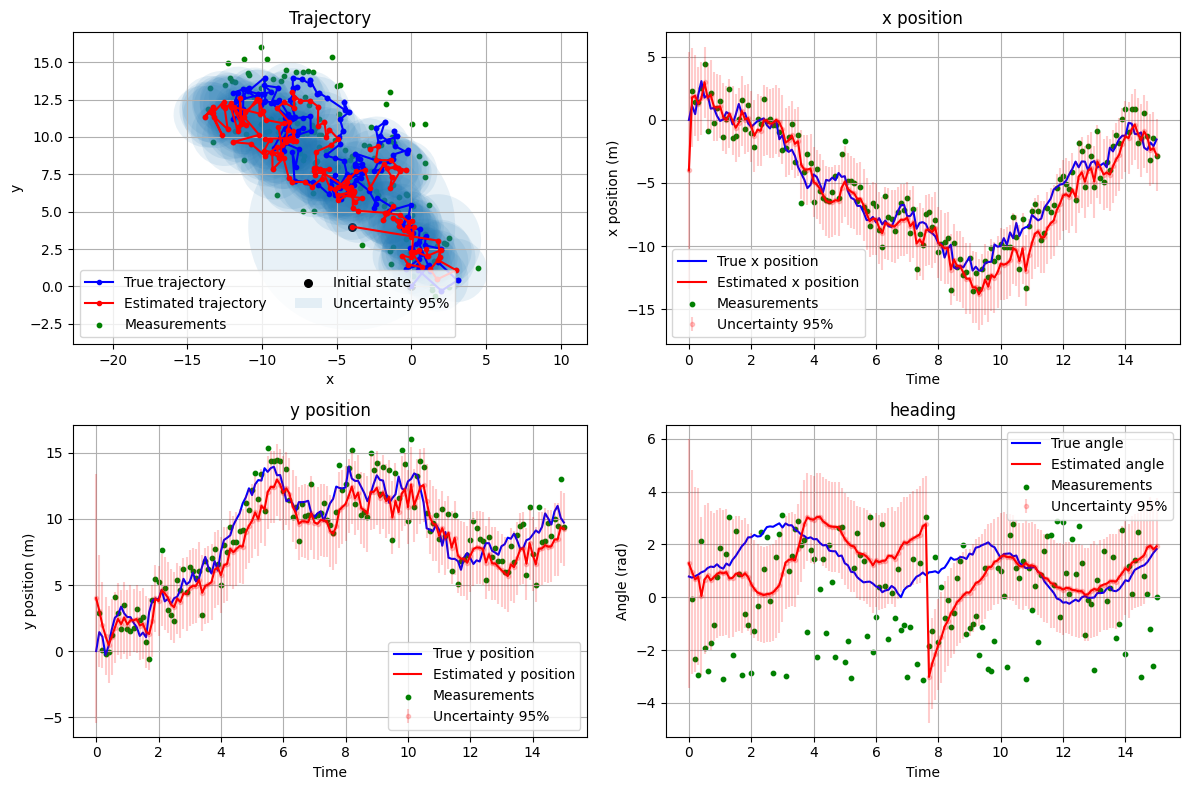

In [31]:
confidence = 0.95
scale = jnp.sqrt(chi2.ppf(0.95, df=5))

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
ax = plt.gca()
plt.plot(xs_true[:, 0], xs_true[:, 1], 'o-', label='True trajectory', color='blue', markersize=3)
plt.plot(xs_est[:, 0], xs_est[:, 1], 'o-', label='Estimated trajectory', color='red', markersize=3)
plt.scatter(xs_true[:, 0], xs_true[:, 1], color='blue', s=10)
plt.scatter(xs_est[:, 0], xs_est[:, 1], color='red', s=10)
plt.scatter(measurements[:, 0], measurements[:, 1], color='green', s=10, label='Measurements')
plt.scatter(xs_est[0, 0], xs_est[0, 1], color='black', s=30, label='Initial state')
plt.scatter(xs_true[0, 0], xs_true[0, 1], color='black', s=30)

plot_uncertainty_ellipse(ax, xs_est[0][:2], Ps[0][:2,:2], confidence=0.95, alpha=0.1, label="Uncertainty 95%")
for (mu, sigma) in zip(xs_est[1:], Ps[1:]):
    plot_uncertainty_ellipse(ax, mu[:2], sigma[:2,:2], confidence=0.95, alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory')
plt.legend(ncol=2)
plt.axis('equal')
plt.grid()

plt.subplot(2,2,2)
plt.plot(ts, xs_true[:, 0], label='True x position', color='blue')
plt.plot(ts, xs_est[:, 0], label='Estimated x position', color='red')
plt.scatter(ts[1:], measurements[:, 0], color='green', s=10, label='Measurements')
plt.errorbar(ts, xs_est[:, 0], yerr=scale * jnp.sqrt(Ps[:, 0, 0]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('x position (m)')
plt.title('x position')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(ts, xs_true[:, 1], label='True y position', color='blue')
plt.plot(ts, xs_est[:, 1], label='Estimated y position', color='red')
plt.scatter(ts[1:], measurements[:, 1], color='green', s=10, label='Measurements')
plt.errorbar(ts, xs_est[:, 1], yerr=scale * jnp.sqrt(Ps[:, 1, 1]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('y position (m)')
plt.title('y position')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(ts, xs_true[:, 2], label='True angle', color='blue')
plt.plot(ts, xs_est[:, 2], label='Estimated angle', color='red')
plt.scatter(ts[1:], measurements[:, 2], color='green', s=10, label='Measurements')
plt.errorbar(ts, xs_est[:, 2], yerr=scale * jnp.sqrt(Ps[:, 2, 2]), fmt='.', color='red', alpha=0.2, label='Uncertainty 95%')
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.title('heading')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

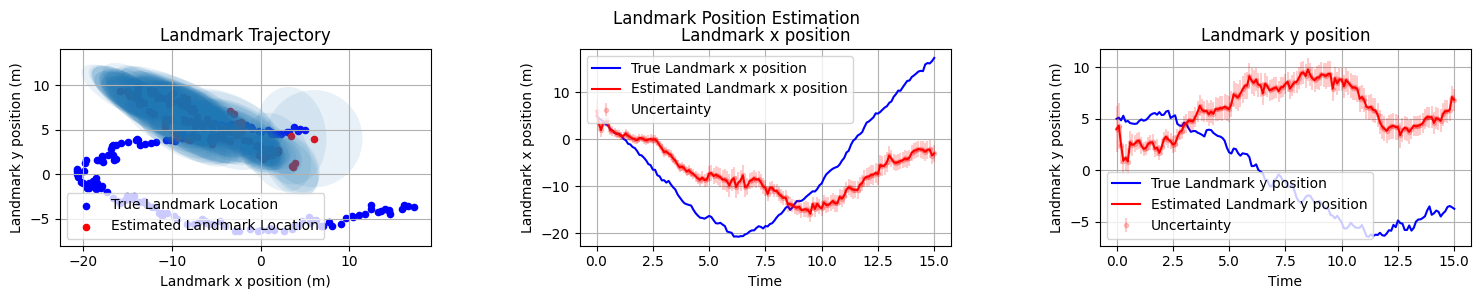

In [32]:
plt.figure(figsize=(15, 3))
plt.subplot(1,3,1)
ax = plt.gca()
plt.scatter(xs_true[:, 3], xs_true[:, 4], label='True Landmark Location', color='blue', s=20, marker='o')
plt.scatter(xs_est[:, 3], xs_est[:, 4], label='Estimated Landmark Location', color='red', s=20, marker='o')
for (mu, sigma) in zip(xs_est, Ps):
    plot_uncertainty_ellipse(ax, mu[3:], sigma[3:,3:], confidence=0.95, alpha=0.1)
plt.xlabel('Landmark x position (m)')
plt.ylabel('Landmark y position (m)')
plt.title('Landmark Trajectory')
plt.legend()
plt.grid()
plt.axis('equal')

plt.subplot(1,3,2)
plt.plot(ts, xs_true[:, 3], label='True Landmark x position', color='blue')
plt.plot(ts, xs_est[:, 3], label='Estimated Landmark x position', color='red')
plt.errorbar(ts, xs_est[:, 3], yerr=jnp.sqrt(Ps[:, 3, 3]), fmt='.', color='red', alpha=0.2, label='Uncertainty')
plt.xlabel('Time')
plt.ylabel('Landmark x position (m)')
plt.title('Landmark x position')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(ts, xs_true[:, 4], label='True Landmark y position', color='blue')
plt.plot(ts, xs_est[:, 4], label='Estimated Landmark y position', color='red')
plt.errorbar(ts, xs_est[:, 4], yerr=jnp.sqrt(Ps[:, 4, 4]), fmt='.', color='red', alpha=0.2, label='Uncertainty')
plt.xlabel('Time')
plt.ylabel('Landmark y position (m)')
plt.title('Landmark y position')
plt.legend()
plt.grid()
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Landmark Position Estimation')
plt.subplots_adjust(top=0.85)
plt.show()

### (e) Interpret your results
This is an open-ended question. Do some exploration and see what kind of results you observed for different values values for $Q$ and $R$. 
Some questions to consider:
- What happens if $Q$ is larger than $R$ and vice versa?
- What if the $Q$ and $R$ values you pick for the EKF does not match the true noise covariance of the true system? (i.e., the covariance matrix used to generate the noise differs from your choice of $Q$ and $R$)
- The heading is probably not handled in the best way in this problem (wrap_to_pi was applied but this causes a discontinous jump at times). Are there better ways to handle this?
- Does the choice of control inputs affect the estimation performance?

#### Answer to the questions

* If Q is larger, than the filter will be more trusting of the measurements. If R was larger, than the filter will trust the prediction model more.
* If the Q and R values did not match the true noise covariance of the system, the estimator will not be optimal. The estimator could still improve the estimate of the states, but will do so in a manner that may not resemle the system to its full potential.
* A better way to handle the heading would be to use a roation matrix for every iteration.
* Control inputs can affect the estimators performance due to fast changing inputs that may be seen as noise depending on the parameters of the filter. 

## Problem 2 (MPC)
In this problem, we will reuse HW2 Problem 4 and simulate the system, but now with some noise added so that the system must replan at each time step to adapt to unforseen changes.

We set up the problem the same as before. (See HW2 Problem 4 for the details)

Below is the code (more or less) copied from HW2 Problem 4.

In [33]:

import cvxpy as cp # import cvxpy

# in this problem, we will use the dynamaxsys library to import dynamical systems implemented in JAX: https://github.com/UW-CTRL/dynamaxsys
from dynamaxsys.simplecar import DynamicallyExtendedSimpleCar
from dynamaxsys.base import get_discrete_time_dynamics
from dynamaxsys.utils import linearize


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
from ipywidgets import interact


In [34]:
# define the robot dynamics
wheelbase = 1.0
dt = 0.1
ct_robot_dynamics = DynamicallyExtendedSimpleCar(wheelbase=wheelbase) # robot dynamics
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
state_dim = dt_robot_dynamics.state_dim
control_dim = dt_robot_dynamics.control_dim




In [35]:
# set up the problem parameters
planning_horizon = 25 # length of the planning horizon
num_time_steps = 50 # number of time steps to simulate
num_sqp_iterations = 15 # number of SQP iterations
t = 0. # this doesn't affect anything, but a value is needed 

# control and velocity limits
v_max = 1.5
v_min = 0.
acceleration_max = 1.0
acceleration_min = -1.0
steering_max = 0.5
steering_min = -0.5

# obstacle parameters
obstacle_location = jnp.array([1.0, 0.0]) # obstacle location
obstacle_location2 = jnp.array([3.0, -0.5]) # obstacle location
obstacle_radius = 0.5 # obstacle radius
robot_radius = 0.1 # robot radius


In [36]:
# some helper functions

# define obstacle function g(x) >= 0
# where g(x) is the distance from the obstacle
@jax.jit
def obstacle_constraint(state, obstacle, radius):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius

# function to simulate the discrete time dynamics given initial state and control sequence
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t = t0
    for c in controls:
        state = dt_dynamics(state, c, t)
        states.append(state)
        t += dt
    return jnp.stack(states)

# function to simulate the discrete time dynamics given initial state and control sequence
# function slightly modified to add noise 
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics_with_noise(dt_dynamics, state, controls, t0, dt, noises):
    states = [state]
    t = t0
    for (c,noise) in zip(controls, noises):
        state = dt_robot_dynamics(state, c, t) + noise * dt
        states.append(state)
        t += dt
    return jnp.stack(states, -1)

# jit the linearize constraint functions to make it run faster
linearize_obstacle = jax.jit(jax.vmap(jax.grad(obstacle_constraint), in_axes=[0, None, None]))

In [37]:
# set up cvxpy problem variables and parameters
xs = cp.Variable([planning_horizon+1, state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([state_dim, state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([state_dim, control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics

Gs = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints
Gs2 = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs2 = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, control_dim]) # parameter for previous solution
initial_state = cp.Parameter([state_dim]) # parameter for current robot state

In [38]:
# set up cvxpy problem cost and constraints
beta1 = 0.2 # coefficient for control effort
beta2 = 5. # coefficient for progress
beta3 = 10. # coefficient for trust region
slack_penalty = 1000. # coefficient for slack variable
markup = 1.0

objective = beta2 * (xs[-1,2]**2 + xs[-1,1]**2 - xs[-1,0]) + beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2
constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
for t in range(planning_horizon):
    objective += (beta1 * cp.sum_squares(us[t]) + beta1 * (xs[t,2]**2 + xs[t,1]**2 - xs[t,0]) ) * markup**t
    constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
    constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,1] <= acceleration_max, us[t,1] >= acceleration_min, us[t,0] <= steering_max, us[t,0] >= steering_min] # control and velocity limit constraints
    constraints += [Gs[t] @ xs[t] + hs[t] >= -slack, Gs2[t] @ xs[t] + hs2[t] >= -slack] # linearized collision avoidance constraint
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= -slack, Gs2[planning_horizon] @ xs[planning_horizon] + hs2[planning_horizon] >= -slack] # constraints for last planning horizon step
prob = cp.Problem(cp.Minimize(objective), constraints) # construct problem
  

In [39]:
# initial states
robot_state = jnp.array([-1.5, -0.5, 0., 1.])  # robot starting state
robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

### (a) Using open-loop solution
Let's compute the open-loop solution for the first time step. Read the next few cells and answer the question at the end.

(Just run the cell below)

In [40]:
initial_state.value = np.array(robot_state)
solver = cp.CLARABEL


for i in range(num_sqp_iterations):
    As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.)
    Gs_value = linearize_obstacle(previous_states, obstacle_location, obstacle_radius + robot_radius) 
    hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)
    Gs2_value = linearize_obstacle(previous_states, obstacle_location2, obstacle_radius + robot_radius) 
    hs2_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location2, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs2_value, previous_states)

    for i in range(planning_horizon):
        As[i].value = np.array(As_value[i])
        Bs[i].value = np.array(Bs_value[i])
        Cs[i].value = np.array(Cs_value[i])
        Gs[i].value = np.array(Gs_value[i])
        hs[i].value = np.array(hs_value[i:i+1])
        Gs2[i].value = np.array(Gs2_value[i])
        hs2[i].value = np.array(hs2_value[i:i+1])
    Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
    hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
    Gs2[planning_horizon].value = np.array(Gs2_value[planning_horizon])
    hs2[planning_horizon].value = np.array(hs2_value[planning_horizon:planning_horizon+1])
    
    result = prob.solve(solver=solver)
open_controls = us.value
    


Fix a covariance matrix to model the process noise, and precompute the noise

(Just run the cell below)

In [41]:
key = jax.random.PRNGKey(0)
n_samples = 64
noise_covar = jnp.diag(jnp.array([0.1, 0.1, 0.05, 0.2])) # noise covariance

noises = jax.random.multivariate_normal(key, jnp.zeros(robot_state.shape), noise_covar, shape=(n_samples, open_controls.shape[0]))

Simulate the dynamics with noise, and without noise

(Just run the cell below)

(Note: `jax.vmap` is becoming handy here!)

In [42]:
noisy_states = jnp.permute_dims(jax.vmap(simulate_discrete_time_dynamics_with_noise, in_axes=[None, None, None, None, None, 0])(dt_robot_dynamics, robot_state, open_controls, 0., dt, noises), (0, 2, 1))
perfect_states = simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, open_controls, 0., dt)

Plot the trajectories

(Just run the cell below)

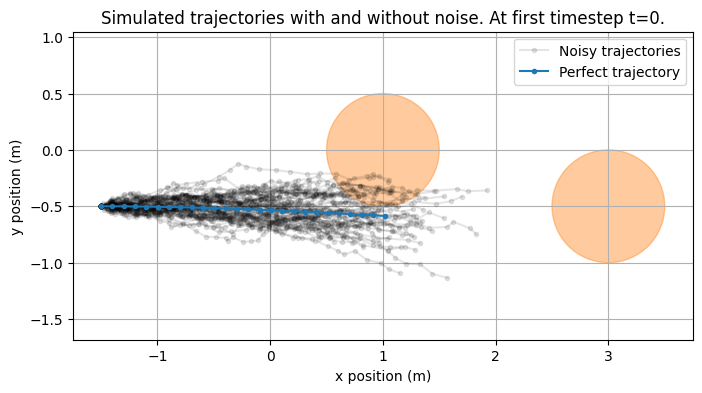

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
robot_position = noisy_states[i, :2]
circle2 = plt.Circle(obstacle_location, obstacle_radius, color='C1', alpha=0.4)
circle3 = plt.Circle(obstacle_location2, obstacle_radius, color='C1', alpha=0.4)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.plot(noisy_states[:,:,0].T, noisy_states[:,:,1].T, "o-", markersize=3, color='black', alpha=0.1)
ax.plot(noisy_states[0,:,0].T, noisy_states[0,:,1].T, "o-", markersize=3, color='black', alpha=0.1, label='Noisy trajectories')
ax.plot(perfect_states[:,0], perfect_states[:,1], "o-", markersize=3, color='C0', label='Perfect trajectory')

ax.set_title("Simulated trajectories with and without noise. At first timestep t=0.")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.set_xlim([-2, 7])
ax.grid()
ax.legend()
ax.axis("equal")
plt.show()


### Comment on what would happen if the robot just executed this open-loop control sequence.

If the robot executed open-loop control, then it will not recalculate the optimal path based on the noise/disturbances. This is problematic because without replanning, it will assume perfect conditions and not ever change its path. 

### (b) Replan at each timestep!
Hopefully you saw from above the need to replan at each time step.
Run the following cells and answer the question at the end.

(Just run the cell below)


In [44]:
# initial states
robot_state = jnp.array([-1.5, -0.5, 0., 1.])  # robot starting state
robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

# precompute the noise
key = jax.random.PRNGKey(0)
noise_covar = jnp.diag(jnp.array([0.1, 0.1, 0.05, 0.2])) # noise covariance
noises = jax.random.multivariate_normal(key, jnp.zeros(robot_state.shape), noise_covar, shape=(num_time_steps,))

Rerun the simulation, replanning at each time step, and adding some noise when computing the robot's next state.

(Just run the cell below)


In [45]:
solver = cp.CLARABEL

for t in range(num_time_steps):
    initial_state.value = np.array(robot_state)
    sqp_solutions = [previous_states]
    
    for i in range(num_sqp_iterations):
        As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.)
        Gs_value = linearize_obstacle(previous_states, obstacle_location, obstacle_radius + robot_radius) 
        hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)
        Gs2_value = linearize_obstacle(previous_states, obstacle_location2, obstacle_radius + robot_radius) 
        hs2_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location2, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs2_value, previous_states)

        for i in range(planning_horizon):
            As[i].value = np.array(As_value[i])
            Bs[i].value = np.array(Bs_value[i])
            Cs[i].value = np.array(Cs_value[i])
            Gs[i].value = np.array(Gs_value[i])
            hs[i].value = np.array(hs_value[i:i+1])
            Gs2[i].value = np.array(Gs2_value[i])
            hs2[i].value = np.array(hs2_value[i:i+1])
        Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
        hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
        Gs2[planning_horizon].value = np.array(Gs2_value[planning_horizon])
        hs2[planning_horizon].value = np.array(hs2_value[planning_horizon:planning_horizon+1])
        
        result = prob.solve(solver=solver)

        
        if us.value is None:
            print("No solution found")
            break
        previous_controls = us.value
        previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)
        sqp_solutions.append(previous_states)
        xs_previous.value = np.array(previous_states)
        us_previous.value = np.array(previous_controls)
    sqp_list.append(np.stack(sqp_solutions))
    robot_control = previous_controls[0]
    robot_control_list.append(robot_control)
    
    # get the robot next state using the control input
    robot_state = dt_robot_dynamics(robot_state, robot_control, 0.) + noises[t] * dt
    
    # clipping the robot velocity so the problem doesn't become infeasible at the next step
    robot_state = robot_state.at[3].set(jnp.clip(robot_state[3], v_min, v_max)) 
    
    # add robot state and trajectory to the list
    robot_trajectory.append(robot_state)
    robot_trajectory_list.append(previous_states)
    
    # update the previous states and controls for the next iteration
    previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)
    
robot_trajectory = jnp.stack(robot_trajectory)
robot_controls = jnp.stack(robot_control_list)

Visualize the results!

(Just run the cell below)


In [46]:
# plotting the results. No need to add comments here. Just run this cell to visualize the results
@interact(i=(0,num_time_steps-1), j=(0,num_sqp_iterations-1))
def plot(i, j):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})
    # fig, axs = plt.subplots(1,2, figsize=(10, 4))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    circle1 = plt.Circle(robot_position, robot_radius, color='C0', alpha=0.4)
    circle2 = plt.Circle(obstacle_location, obstacle_radius, color='C1', alpha=0.4)
    circle3 = plt.Circle(obstacle_location2, obstacle_radius, color='C1', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=3, color='black')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='red', label="Planned")
    # Plot planned trajectory for the selected SQP iteration
    planned_trajectory = sqp_list[i][j]
    ax.plot(planned_trajectory[:, 0], planned_trajectory[:, 1], "o-", markersize=3, color='green', alpha=0.4, label="SQP iteration %d" % j)
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C0', label="Robot")
    ax.set_xlim([-2, 7])
    ax.grid()
    ax.legend()
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    ax = axs[1]
    ax.plot(robot_controls)
    ax.scatter([i], robot_controls[i:i+1, 0], label="$tan(\\delta)$", color='C0')
    ax.scatter([i], robot_controls[i:i+1, 1], label="Acceleration", color='C1')

    ax.hlines(steering_min, 0, num_time_steps-1, color='C0', linestyle='--')
    ax.hlines(steering_max, 0, num_time_steps-1, color='C0', linestyle='--')
    ax.hlines(acceleration_min, 0, num_time_steps-1, color='C1', linestyle='--')
    ax.hlines(acceleration_max, 0, num_time_steps-1, color='C1', linestyle='--')
    
    ax.plot(robot_trajectory[:,-1], markersize=3, color='C2')
    ax.scatter([i], robot_trajectory[i:i+1, 3], label="Velocity", color='C2')
    ax.hlines(v_min, 0, num_time_steps-1, color='C2', linestyle='--')
    ax.hlines(v_max, 0, num_time_steps-1, color='C2', linestyle='--')
    ax.set_xlim([0, num_time_steps])
    ax.set_ylim([-2, 2])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Control")
    ax.set_title("Velocity, steering and acceleration")
    ax.legend()
    ax.grid()

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=7, description='j', max=14…

Is it guaranteed that your system will not hit the obstacle if we just apply MPC in the way we did above?
If not, what are some techniques you could try to reduce the risk of colliding into the obstacles?

(Optional) What if the obstacles were not stationary. But rather, they were moving. How would the problem change if the obstacle's motion were fully known (e.g., we knew exactly where the obstacle would be at any point in time), or if the obstacle's motion was uncertain (e.g., the obstacles were pedestrians, or space debris whose motion is not fully known). What are some techniques that could be applied to reduce the risk of collision?

#### Answer to problem above

* It is not gauranteed that we will not hit the obstacle. Some solutions include using a CBF for a BRT to ensure that the robot, although experiancing disturbances will always maintain a safe position. This will turn into a set of safe controls that the robot can use to navigate safely. Another solution may be to always assume the worst possible disturbance (assuming that you can quantify this value) this will ensure that even with the highest magnitude disturbances, the robot can still operate safely. 